<a href="https://colab.research.google.com/github/mdznsk/NYC-restaurant-inspections/blob/master/Copy_of_Final_Project_Restaurant_Grades_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
# import libraries needed
import pandas as pd 
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Data import and pre-processing

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_excel('/content/drive/My Drive/jedha fundies/Data/100k lines_Data NYC restaurants.xlsx')

In [ ]:
dataset.head()

,ÔªøCAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50070206,BLUE CAFE RESTAURANT & BAR,Queens,8263,BROADWAY,11373.0,7183960717,Spanish,2018-11-01 00:00:00,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140¬∫ F.,Y,14.0,NaN,NaN,07/20/2020,Pre-permit (Operational) / Initial Inspection,40.741920,-73.881125,404.0,25.0,27100.0,4037524.0,4.015180e+09,QN29
1,41713504,ISIS RESTAURANT,Bronx,739,ALLERTON AVENUE,10467.0,7183241054,Mexican,2019-09-10 00:00:00,Establishment Closed by DOHMH. Violations wer...,08A,Facility not vermin proof. Harborage or condit...,N,40.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.865466,-73.865700,211.0,15.0,33800.0,2053637.0,2.045100e+09,BX07
2,41674628,MANHATTAN PROPER,Manhattan,6,MURRAY STREET,10007.0,6465594445,American,02/26/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,20.0,B,02/26/2019,07/20/2020,Cycle Inspection / Re-inspection,40.713222,-74.007622,101.0,1.0,2100.0,1001407.0,1.001240e+09,MN24
3,50012117,ROBERTA'S PIZZA & BAKERY,Brooklyn,261,MOORE STREET,11206.0,7184171118,Pizza,2019-01-05 00:00:00,No violations were recorded at the time of thi...,NaN,NaN,NaN,0.0,NaN,NaN,07/20/2020,Inter-Agency Task Force / Initial Inspection,40.704818,-73.934015,301.0,34.0,48500.0,3071483.0,3.031010e+09,BK78
4,41022489,LA CANOA,Queens,651,ONDERDONK AVENUE,11385.0,7184566011,"Latin (Cuban, Dominican, Puerto Rican, South &...",02/24/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,24.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.704525,-73.908126,405.0,34.0,54700.0,4082889.0,4.034670e+09,QN20


In [ ]:
dataset.isnull().sum()

ÔªøCAMIS                     0
DBA                        136
BORO                         0
BUILDING                   461
STREET                      30
ZIPCODE                   2527
PHONE                       11
CUISINE DESCRIPTION          0
INSPECTION DATE              0
ACTION                     682
VIOLATION CODE            2309
VIOLATION DESCRIPTION     3585
CRITICAL FLAG             3585
SCORE                     6502
GRADE                    74275
GRADE DATE               75242
RECORD DATE                  0
INSPECTION TYPE            682
Latitude                   603
Longitude                  603
Community Board           3088
Council District          3088
Census Tract              3088
BIN                       3786
BBL                        603
NTA                       3088
dtype: int64

In [ ]:
# removing rows with no score or grade
dataset = dataset.dropna(subset=['SCORE','GRADE'])

# checking
dataset.isnull().sum()

ÔªøCAMIS                    0
DBA                         0
BORO                        0
BUILDING                  290
STREET                     18
ZIPCODE                  1310
PHONE                       7
CUISINE DESCRIPTION         0
INSPECTION DATE             0
ACTION                      0
VIOLATION CODE            387
VIOLATION DESCRIPTION     672
CRITICAL FLAG             672
SCORE                       0
GRADE                       0
GRADE DATE                964
RECORD DATE                 0
INSPECTION TYPE             0
Latitude                  367
Longitude                 367
Community Board          1653
Council District         1653
Census Tract             1653
BIN                      2005
BBL                       367
NTA                      1653
dtype: int64

In [ ]:
# converting SCORE to int
dataset.SCORE = dataset.SCORE.astype(int)

# removing rows where C grade is not 28+ points
index_remove = dataset[(dataset['SCORE'] <= 27) & (dataset['GRADE'] == 'C')].index
dataset.drop(index_remove, inplace=True)

# renaming columns
dataset = dataset.rename(
    columns={
        "ÔªøCAMIS": "Restaurant ID",
        "DBA": "Restaurant Name",
        "CUISINE DESCRIPTION": "Cuisine"
            })

# deleting columns we won't use
dataset = dataset.drop(["BUILDING",
                        "PHONE",
                        "Community Board",
                        "Council District",
                        "Census Tract",
                        "BIN",
                        "BBL",
                        "NTA",
                        "Restaurant Name",
                        "Restaurant ID",
                        "STREET",
                        "ACTION",
                        "VIOLATION DESCRIPTION",
                        "INSPECTION TYPE",
                        "GRADE DATE",
                        "RECORD DATE",
                        "Latitude",
                        "Longitude",
                        "ZIPCODE",
                        "INSPECTION DATE",
                        "CRITICAL FLAG",
                        "RECORD DATE"], axis=1)

## Dummy-fying borough values

In [ ]:
# turn qualitative values into quantitative
# starting with boro
dummies_boro = pd.get_dummies(dataset['BORO'], drop_first=True)
dummies_boro.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,1,0,0,0,0
10,0,0,1,0,0


In [ ]:
dataset = dataset.merge(dummies_boro, left_index=True, right_index=True)
dataset.head()

,BORO,Cuisine,VIOLATION CODE,SCORE,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2,Manhattan,American,04L,20,B,0,0,1,0,0
5,Manhattan,Japanese,08A,11,A,0,0,1,0,0
6,Staten Island,Vietnamese/Cambodian/Malaysia,10F,8,A,0,0,0,0,1
7,Bronx,Spanish,10B,10,A,1,0,0,0,0
10,Manhattan,Seafood,10B,13,A,0,0,1,0,0


## Merging cuisine types for easier data analysis
We have 84 different cuisine types. It will be easier to merge them into categories to understand the data and see which features have influence in our models.
We will group cuisine types by continent.

In [ ]:
dataset.Cuisine.nunique()

84

In [ ]:
dataset.Cuisine.unique()

array(['American', 'Japanese', 'Vietnamese/Cambodian/Malaysia', 'Spanish',
       'Seafood', 'Donuts', 'Indian', 'Delicatessen', 'Chicken', 'French',
       'Bakery', 'Chinese', 'Caribbean', 'Turkish',
       'Bottled beverages, including water, sodas, juices, etc.', 'Thai',
       'Hamburgers', 'Jewish/Kosher', 'Ice Cream, Gelato, Yogurt, Ices',
       'Hotdogs', 'Vegetarian', 'Pizza', 'Greek', 'Caf√©/Coffee/Tea',
       'Steak', 'Armenian', 'African', 'Tex-Mex', 'Filipino',
       'Juice, Smoothies, Fruit Salads', 'Mexican', 'Pizza/Italian',
       'Korean', 'Asian',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Italian', 'Soul Food', 'Russian', 'Brazilian', 'Mediterranean',
       'Chinese/Cuban', 'Bagels/Pretzels', 'Continental', 'Peruvian',
       'Bangladeshi', 'Eastern European',
       'Sandwiches/Salads/Mixed Buffet', 'English', 'Other', 'Irish',
       'Ethiopian', 'Hawaiian', 'Sandwiches', 'Salads', 'Middle Eastern',
       'Moroccan', 'B

In [ ]:
dataset['Cuisine'] = dataset['Cuisine'].replace(['Iranian','Middle Eastern','Indonesian','Bangladeshi','Afghan','Indian','Turkish','Japanese','Vietnamese/Cambodian/Malaysia','Korean','Asian','Filipino','Chinese/Japanese','Chinese','Thai'],'Asia')
dataset['Cuisine'] = dataset['Cuisine'].replace(['Spanish','Italian','French','English','Eastern European','Mediterranean','Greek','Russian','German','Irish','Polish','Portuguese','Czech','Basque','Scandinavian'],'Europe')
dataset['Cuisine'] = dataset['Cuisine'].replace(['American','Donuts','Caribbean','Tex-Mex','Mexican','Latin (Cuban, Dominican, Puerto Rican, South & Central American)','Brazilian','Chinese/Cuban','Soul Food','Peruvian','Bagels/Pretzels','Hawaiian','Barbecue','Southwestern','Cajun','Creole/Cajun','Californian','Chilean'], 'Americas')
dataset['Cuisine'] = dataset['Cuisine'].replace(['Ethiopian','Egyptian','Moroccan'],'Africa')
dataset['Cuisine'] = np.where(dataset['Cuisine'].isin(['Asia','Africa','Americas','Europe']), dataset['Cuisine'], 'Others')
print(dataset.Cuisine.unique())
print(dataset.Cuisine.nunique())

['Americas' 'Asia' 'Europe' 'Others' 'Africa']
5


## Dummy-fying cuisine and violation codes

In [ ]:
# same thing with cuisine and violation code
dummies_cuisine = pd.get_dummies(dataset['Cuisine'], drop_first=True)
dataset = dataset.merge(dummies_cuisine, left_index=True, right_index=True)
dummies_code = pd.get_dummies(dataset['VIOLATION CODE'], drop_first=True)
dataset = dataset.merge(dummies_code, left_index=True, right_index=True)

In [ ]:
# creating a second dataframe where we remove GRADE as we first need only numeric values for the multivariate linear regression
dataset_num = dataset.drop(['BORO','Cuisine','VIOLATION CODE','GRADE'], axis=1)

#  Predicting SCORE

## Linear regression multi-variable

In [ ]:
# defining X and y, y being the SCORE and X being all other columns *not SCORE*
y = dataset_num["SCORE"]
X = dataset_num.drop("SCORE", axis=1)

In [ ]:
# removing -1 -0 scores
dataset_num= dataset_num.drop(dataset_num[(dataset_num['SCORE'] == -1)].index)
dataset_num= dataset_num.drop(dataset_num[(dataset_num['SCORE'] == -0)].index)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [ ]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("Score Train:",reg.score (X_train, y_train))
print("Score Test:",reg.score (X_test, y_test))

Score Train: 0.10793363162894298
Score Test: -5.291859300077166e+18


In [ ]:
predictions = reg.predict(X_test)
print(predictions[0:50])

[11.92220606 14.08086557 10.82732848 14.8124568  14.81454091 18.28018676
  1.37643286 10.91626246 15.48793176 11.85481652 11.69995302 10.91626246
 10.25069297 12.56752666 12.13841291 12.65140859 12.70941325 11.26528065
 12.56752666 15.8281222  12.78659999 15.86597068 11.77093459 12.65140859
 12.66271186 10.2613802  15.90970377 12.14575465 15.89910377  9.81671514
 14.18741532 16.97682128 11.26528065 11.77093459 12.71561842 10.32167454
 11.80685959 12.21559965 14.88343838 13.71378832 15.26099701 11.69995302
  9.31106119 11.77093459  9.90059707  9.74573357  9.81671514  9.39494312
 11.58515967 11.77093459]


In [ ]:
# comparing predictions vs y_test
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(predictions_df.head(50))

        Actual  Predicted
88553       12  11.922206
122979      22  14.080866
30057       10  10.827328
48511       21  14.812457
122485      18  14.814541
58742       27  18.280187
76167        0   1.376433
44838        2  10.916262
133288      12  15.487932
72718        8  11.854817
33980       12  11.699953
23532        8  10.916262
50531        8  10.250693
48859       11  12.567527
112524       7  12.138413
103425      13  12.651409
87810       13  12.709413
90651       13  11.265281
16015       12  12.567527
25367       11  15.828122
82674       44  12.786600
123959      25  15.865971
139987      10  11.770935
65528       13  12.651409
57422       24  12.662712
27101        4  10.261380
119984      12  15.909704
67062       33  12.145755
124181      11  15.899104
79697       12   9.816715
41261       33  14.187415
63220       19  16.976821
353          8  11.265281
18284       12  11.770935
112897      11  12.715618
19681        6  10.321675
76046       11  11.806860
145605      

Text(0.5, 1.0, 'Actual scores vs model predictions')

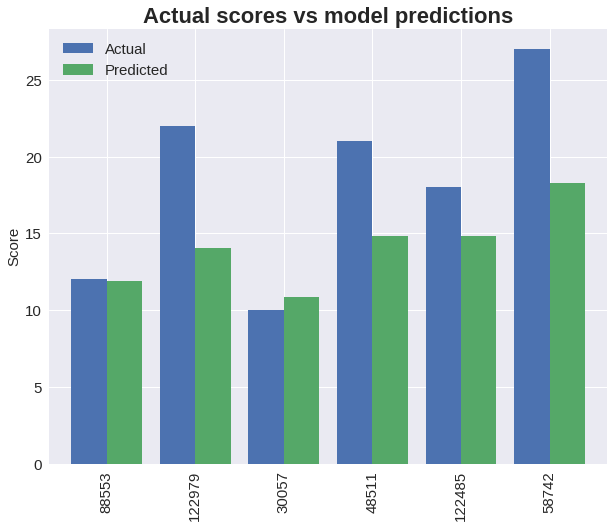

In [ ]:
# plotting actual vs predicted values
pred_plot = predictions_df.head(6)
pred_plot.plot(kind='bar',figsize=(10,8), fontsize=15, width=0.8)
plt.ylabel('Score', fontsize=15)
plt.legend(fontsize= 15)
plt.title('Actual scores vs model predictions', fontsize=22, fontweight='bold')

In [ ]:
coef_reg = pd.DataFrame({"Features":dataset_num.columns[1:],
                                    "Coef": reg.coef_})

coef_reg.nlargest(10, 'Coef')

,Features,Coef
24,04B,7.755683e+11
54,08A,4.094116e+00
65,10F,3.376831e+00
33,04L,3.231812e+00
14,02G,3.061874e+00
35,04N,2.971558e+00
9,02B,2.852318e+00
46,06C,2.828369e+00
47,06D,2.769653e+00
61,10B,2.633057e+00


## Random forest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(min_samples_split=30, max_depth=550, min_samples_leaf=30)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=550, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=30,
                      min_samples_split=30, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print("Score train:", rfreg.score(X_train, y_train))
print("Score test:", rfreg.score(X_test, y_test))

Score train: 0.08717454108946965
Score test: 0.0817111081839953


In [ ]:
# putting feature importance in a dataframe
feature_importance_rfreg = pd.DataFrame({"Features":dataset_num.columns[1:],
                                    "Value": rfreg.feature_importances_})

# getting the top 10
feature_importance_rfreg.nlargest(10, 'Value')

,Features,Value
65,10F,0.371221
61,10B,0.059403
47,06D,0.059136
59,09C,0.038418
46,06C,0.033771
23,04A,0.032041
6,Asia,0.032001
68,10I,0.030861
40,05D,0.027643
8,Others,0.026783


***Understanding feature importance table***

*These violation codes are the most important in predicting the SCORE with this RandomForestRegressor model*


**10F**  Non-food contact surface improperly constructed.

**06D** Food contact surface not washed, rinsed or sanitized after each use.

**10B** Plumbing not properly maintained or installed.

**09C** Food contact surface not properly maintained.


# GRADE Decision tree modeling

## First tree

In [ ]:
# we take our 'initial' dataset and drop SCORE
dataset_categ = dataset.drop(['SCORE'], axis=1)

In [ ]:
# dropping non dummies columns
dataset_categ = dataset_categ.drop(['BORO','Cuisine','VIOLATION CODE'], axis=1)
dataset_categ.head(5)

,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Americas,Asia,Europe,Others,02B,02C,02D,02E,02F,02G,02H,02I,03A,03B,03C,03D,03E,03G,04A,04B,04C,04D,04E,04F,04G,04H,04J,04K,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,22F,22G
2,B,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,A,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,A,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,A,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,A,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# removing grades that aren't A/B/C (the other letter grades mean that the grade is pending and thus aren't useful here)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'N')].index)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'Z')].index)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'P')].index)
dataset_categ = dataset_categ.drop(dataset_categ[(dataset_categ['GRADE'] == 'G')].index)
dataset_categ.GRADE.unique()

array(['B', 'A', 'C'], dtype=object)

In [ ]:
# defining X and y, y being the GRADE and X being all other columns *not GRADE*
y = dataset_categ["GRADE"]
X = dataset_categ.drop("GRADE", axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# evaluating model scores
print("Score train:", classifier.score(X_train, y_train))
print("Score test:", classifier.score(X_test, y_test))

Score train: 0.5664948186975188
Score test: 0.5564137931034483


In [ ]:
pred_tree = classifier.predict(X_test)
# comparing predictions vs y_test
pred_tree_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_tree})
pred_tree_df.head(75)

,Actual,Predicted
33807,A,A
49327,A,C
144520,A,B
92348,A,A
109079,A,A
...,...,...
76936,C,A
103630,A,C
97525,B,C
13482,A,B


In [ ]:
# split of predictions by categories
print(np.unique(pred_tree, return_counts=True))

(array(['A', 'B', 'C'], dtype=object), array([7640, 4183, 2677]))


### Plotting distribution GRADE predictions tree vs original distribution

Text(0.5, 1.0, 'Distribution GRADE in dataset')

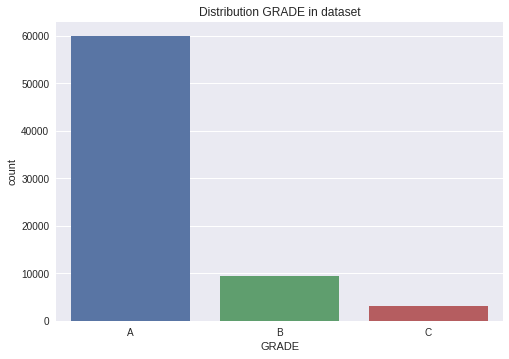

In [ ]:
sb.countplot(x='GRADE', data=dataset_categ,order=['A', 'B', 'C']).set_title('Distribution GRADE in dataset')

Text(0.5, 1.0, 'Distribution GRADE tree model')

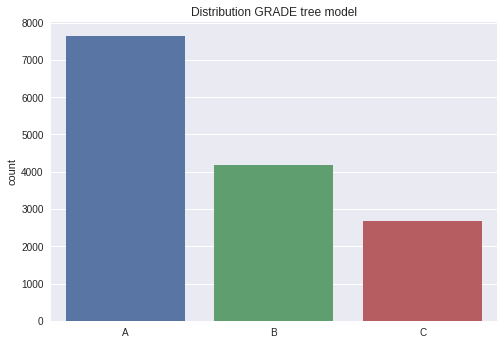

In [ ]:
sb.countplot(x=pred_tree, data=pred_tree_df,order=['A', 'B', 'C']).set_title('Distribution GRADE tree model')

### Feature importance tree model

In [ ]:
# putting feature importance in a dataframe
feature_importance = pd.DataFrame({"Features":dataset_categ.columns[1:],
                                    "Value": classifier.feature_importances_})

# getting the top 10
feature_importance.nlargest(10, 'Value')

,Features,Value
65,10F,0.216973
1,Brooklyn,0.051238
2,Manhattan,0.049325
3,Queens,0.043693
47,06D,0.039772
6,Asia,0.039055
61,10B,0.035487
59,09C,0.034553
0,Bronx,0.031590
7,Europe,0.030166


# GRADE Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print("Score train:",forest.score(X_train, y_train))
print("Score test:",forest.score(X_test, y_test))
print("Estimateur naïf score:", forest.score(X_test, np.array(['A'] * len(y_test))))

Score train: 0.5824094349707744
Score test: 0.5731724137931035
Estimateur naïf score: 0.5471724137931034


In [ ]:
pred_forest = forest.predict(X_test)
# comparing predictions vs y_test
pred_forest_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_forest})
pred_forest_df.head(75)

,Actual,Predicted
33807,A,A
49327,A,C
144520,A,B
92348,A,A
109079,A,A
...,...,...
76936,C,A
103630,A,C
97525,B,C
13482,A,B


## Plotting distribution GRADE predictions random forest vs dataset distribution

In [ ]:
# split predictions 
print("predictions split:", np.unique(pred_forest, return_counts=True)
print("versus distribution in dataset:", np.unique(dataset['GRADE'], return_counts=True)
# A extremely in majority in dataset, the split of predictions is a bit too balanced

NameError: ignored

In [ ]:
sb.countplot(x='GRADE', data=dataset_categ,order=['A', 'B', 'C']).set_title('Distribution GRADE in dataset')

In [ ]:
sb.countplot(x=pred_forest, data=pred_forest_df, order=['A', 'B', 'C']).set_title('Distribution GRADE with random forest')

## Confusion matrix

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['A', 'B', 'C']
cm = confusion_matrix(y_test, forest.predict(X_test), labels)
cm

In [ ]:
ax = plt.subplot()
sb.heatmap(cm, annot=True, fmt=".0f", cmap='Greens', ax = ax)
ax.set_xlabel('Predicted grades')
ax.set_ylabel('True grades')
ax.set_title('Confusion Matrix Random Forest')
ax.xaxis.set_ticklabels(['A', 'B', 'C']); ax.yaxis.set_ticklabels(['A', 'B', 'C'])

In [ ]:
# putting feature importance in a dataframe
feature_importance_forest = pd.DataFrame({"Features":dataset_categ.columns[1:],
                                    "Value": forest.feature_importances_})

# getting the top 10
feature_importance_forest.nlargest(10, 'Value')

# GRADE Naive classification

In [ ]:
from sklearn.naive_bayes import GaussianNB
naiveb = GaussianNB()
naiveb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print("Score train:",naiveb.score(X_train, y_train))
print("Score test:",naiveb.score(X_test, y_test))
print("Estimateur naïf score:", naiveb.score(X_test, np.array(['A'] * len(y_test))))

Score train: 0.7903167405210615
Score test: 0.7899310344827586
Estimateur naïf score: 0.9084827586206896


In [ ]:
pred_naiveb = naiveb.predict(X_test)
pred_naiveb_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_naiveb})
pred_naiveb_df.head(75)

,Actual,Predicted
33807,A,A
49327,A,A
144520,A,A
92348,A,A
109079,A,A
...,...,...
76936,C,A
103630,A,A
97525,B,A
13482,A,A


## Plotting distribution of GRADE predictions by naive bayes model vs original dataset

In [ ]:
pred_array = np.unique(pred_naiveb, return_counts=True)
distrib_array = np.unique(dataset['GRADE'], return_counts=True)
print("predictions split:", pred_array)
print("versus distribution in dataset:", distrib_array)

predictions split: (array(['A', 'B', 'C'], dtype='<U1'), array([13173,  1082,   245]))
versus distribution in dataset: (array(['A', 'B', 'C', 'G', 'N', 'P', 'Z'], dtype=object), array([59976,  9406,  3115,     3,   966,   991,  1162]))


Text(0.5, 1.0, 'Distribution GRADE in dataset')

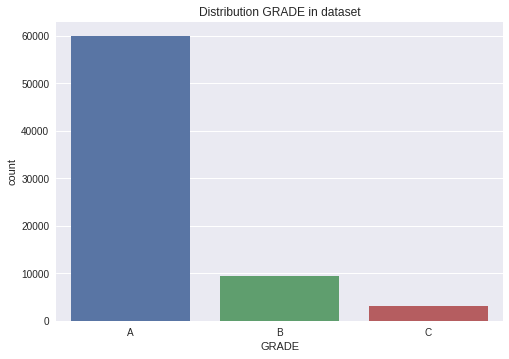

In [ ]:
sb.countplot(x='GRADE', data=dataset_categ,order=['A', 'B', 'C']).set_title('Distribution GRADE in dataset')

Text(0.5, 1.0, 'Distribution GRADE naive bayes model')

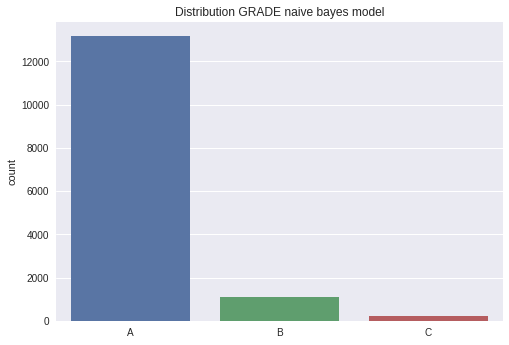

In [ ]:
sb.countplot(x= pred_naiveb, data=pred_naiveb_df, order=['A', 'B', 'C']).set_title('Distribution GRADE naive bayes model')

Compared to the random forest or tree, the naive bayes prediction split follows the distribution of the original dataset a lot better.

# Just for fun: predicting GRADE based on SCORE
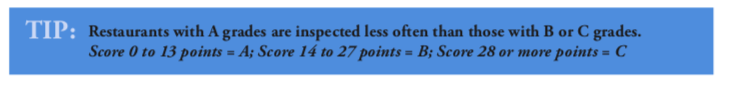

In [ ]:
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'N')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'Z')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'P')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'G')].index)
dataset.GRADE.unique()

array(['B', 'A', 'C'], dtype=object)

In [ ]:
X_fun = dataset["SCORE"]
y_fun = dataset["GRADE"]

In [ ]:
# casting SCORE as integer
# removing -1 and 0 scores (irrelevant)
dataset.SCORE = dataset.SCORE.astype(int)
dataset= dataset.drop(dataset[(dataset['SCORE'] == -1)].index)
dataset= dataset.drop(dataset[(dataset['SCORE'] == -0)].index)

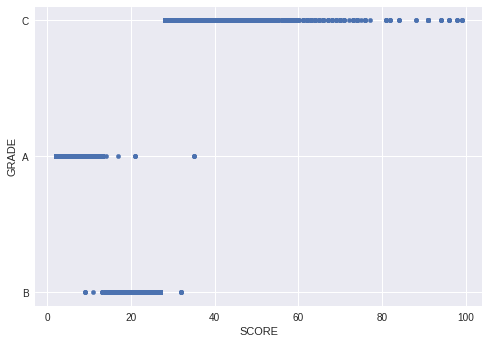

In [ ]:
dataset.plot(kind='scatter', x='SCORE', y='GRADE')

The scatter plot shows the relation between SCORE <> GRADE.

In [ ]:
from sklearn.model_selection import train_test_split
X_fun_train, X_fun_test, y_fun_train, y_fun_test = train_test_split(X_fun, y_fun, test_size=0.2, random_state=0)

In [ ]:
X_fun_train = X_fun_train.values.reshape(-1,1)
X_fun_test = X_fun_test.values.reshape(-1,1)

## log regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_fun = LogisticRegression()
log_fun.fit(X_fun_train, y_fun_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("Score train:", log_fun.score(X_fun_train, y_fun_train))

Score train: 0.993327241064193


In [ ]:
print("Score test:", log_fun.score(X_fun_test, y_fun_test))

Score test: 0.992551724137931


In [ ]:
pred_log = log_fun.predict(X_fun_test)
print(np.unique(pred_log, return_counts=True))

(array(['A', 'B', 'C'], dtype=object), array([12087,  1769,   644]))


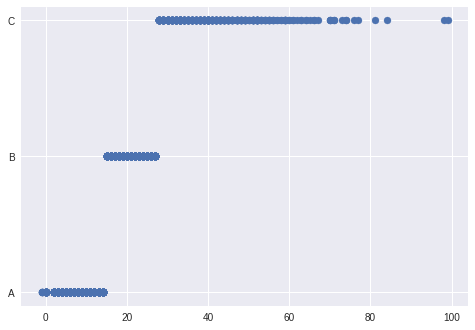

In [ ]:
plt.scatter(X_fun_test, pred_log)

### confusion matrix reverse engineering log reg

[[11981     1     1]
 [  106  1768     0]
 [    0     0   643]]


[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C')]

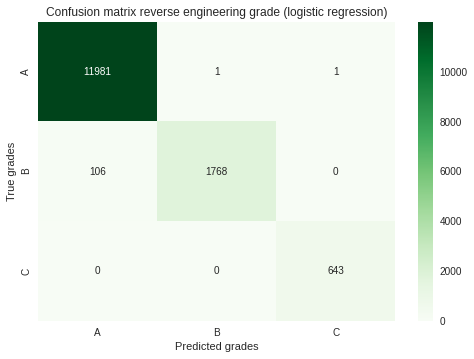

In [ ]:
# confusion matrix
cm_log = confusion_matrix(y_fun_test, pred_log)
cm_log
print(cm_log)

ax = plt.subplot()
sb.heatmap(cm_log, annot=True, fmt=".0f", cmap='Greens', ax = ax)
ax.set_xlabel('Predicted grades')
ax.set_ylabel('True grades')
ax.set_title('Confusion matrix reverse engineering grade (logistic regression)')
ax.xaxis.set_ticklabels(['A', 'B', 'C']); ax.yaxis.set_ticklabels(['A', 'B', 'C'])

## Verifying it understood SCORE <> GRADE correctly

In [ ]:
print(log_fun.predict([[12]]))
print(log_fun.predict([[22]]))
print(log_fun.predict([[40]]))

# with this code cell we can see that the 0-13 A , 14-27 B , 28+ C thresholds are understood by the logistic regressor :) 

['A']
['B']
['C']
